In [13]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from tensorflow.keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import math
import Simulator_Functions as SF

from Actor_Critic_Agents import ACAgent

from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from Utilities import log_progress, pltlive
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
import PER

%matplotlib inline

ERROR: GPU DEVICE NOT FOUND.


In [14]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 100
partial_save_at =  50 # 100 
copy_weights_frequency = 10 #10


# Hyperparameters
Surtrac = False
PER_activated = True
batch_size = 64
memory_size = 1024
alpha   = 0.000065
gamma   = 0.95

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1
Random_Seed = 42
memory_population_length = batch_size*seconds_per_green*2 +1
if PER_activated:
    memory_population_length = int(memory_size*seconds_per_green*2) +1

# Vissim autosave the result of the simulation    
delete_results = True

## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 57 #4  17 33 49 97
action_size = 2 # 8 



# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 1
epsilon_end   = 0.001
if exploration_schedule == "linear":
    epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
    epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
    epsilon_sequence = [0 if entry < 0 else entry for entry in epsilon_sequence]
elif exploration_schedule == "geometric":
    epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
    epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
else:
    print("ERROR: Unrecognized choice of exploration schedule.")

# Demand Schedule (times in seconds, demand in cars/hour as PPP)  # worked with 600 and demand = {"h":600, 'm':300, 'l':150}
demand_change_timesteps = 450
demand = {"h":600, 'm':300, 'l':150}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]

In [18]:
## Operation mode (selects functionalities)
mode = "demo"
# "populate" = population of memory, generation of initial memory file
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed
# "retraining" = continue to train agents, maximum speed, frozen UI, mid amount of messages. T

if mode == 'demo' :
    simulation_length = 3600
    demand_list = [[demand['l'], demand['l']]]
    demand_change_timesteps = simulation_length
    
    
if mode == 'test' : 
    simulation_length = 3600
    demand_change_timesteps = 450
    demand = {"h":800, 'm':400, 'l':200}
    demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
                  [demand['h'], demand['l']], [demand['h'], demand['m']],\
                  [demand['h'], demand['h']], [demand['m'], demand['h']],
                  [demand['l'], demand['h']], [demand['l'], demand['m']]]
    delete_results = False

model_name  = 'Single_Cross_Mod2'
# 'Single_Cross_Straight'
# 'Single_Cross_Triple'
# 'Single_Cross_Triple_Mod'
# 'Single_Cross_Mod2'
# 'Balance'

vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'  #'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
agent_type = 'DuelingDDQN'        # DQN, DuelingDQN, DDQN, DuelingDDQN AC
reward_type = 'Queues'   
# 'Queues'          Sum of the queues for all lanes in intersection
# 'QueuesDiff'      Difference in queue lengths in last timestep
# 'QueuesDiffSC'    10000* QueuesDiff - Queues^2
# 'TotalDelayDiff'
state_type  = 'CellsSpeedOccSig'
#CellsSpeedOccSig'    # 'Queues', 'Delays', 'QueuesDifference' 'QueuesSpeedavrOccuperateSig' 'QueuesSig' CellsSpeedSig 
#CellsSpeedOccSig 'CellsOccSig' 'CellsT'


#hyper parameters of the AC agent
if agent_type == 'AC':
    alpha   = 0.000065
    gamma   = 0.99
    n_step_size = 32 # number of step in the n step learning # 32
    PER_activated = False
    entropy = 0.0001



## Use of additional files?
flag_read_additionally  = False
SaveResultsAgent = True
# Random demand
Random_Demand = False

# Session ID
# Adding the state type to the Session_ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_State_"+state_type+"_Act_"+action_type+"_Rew_"+reward_type
print(Session_ID)

Ep_100_A_DuelingDDQN_State_CellsSpeedOccSig_Act_phases_Rew_Queues


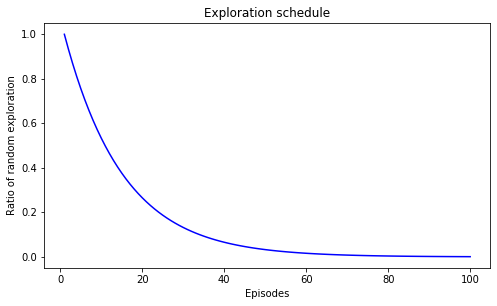

In [19]:
# Plotting exploration schedule
plt.figure(figsize=(8,4.5))
x_series = np.array(range(1,episodes+1))
y_series = epsilon_sequence[0:episodes]
plt.plot(x_series, y_series, '-b')
plt.xlabel('Episodes')
plt.ylabel('Ratio of random exploration')
plt.title('Exploration schedule')
plt.show()

In [20]:
# Have to find a way to reduce entropy over time entropy = exploration

## Converging network
# - reward queue, state queue
# converging with updates every steps and entropy = 0.00001 and 1 core layer of 42
# converging well with updates every steps and entropy = 0.00001 and 1 core layer of 128

# - reward queue state queues + sig
# converging well with updates every steps and entropy = 0.00001 and 1 core layer of 128





if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                memory_population_length if mode == 'training'\
                                                                and PER_activated else simulation_length ,\
                                                                timesteps_per_second,\
                                                                delete_results = delete_results, verbose = True)
    
    SF.Select_Vissim_Mode(Vissim,mode)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or agent_type =="DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or agent_type == "DDQN" else True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif agent_type in ['AC'] :
        Agents = [ACAgent(state_size, action_size, ID, state_type, npa, n_step_size, gamma, alpha, entropy, Vissim) for ID in npa.signal_controllers_ids] 
        for agent in Agents:
            # to initialise the computational graph ot the model (I am sure there is a better way to to this)
            agent.test()
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    ## EXECUTION OF A DEMONSTRATION, POPULATION, DEBUG OR TEST ITERATION
    if mode == "demo" or mode == "populate" or mode == "debug" or mode == "test":
        # If mode or debug, set slow simulation
        if mode == "demo" or mode =="debug":
            timesteps_per_second = 10
            Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
            
        # If memory population or test mode, set quick simulation
        elif mode == "populate" or mode == "test":
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            
        # If on a test or a demo, load the best available agent and set exploration to zero
        if mode == "demo" or mode == "test":
            Agents, reward_storage = SF.load_agents(vissim_working_directory, model_name, Agents,\
                                    Session_ID, best = True)
            for agent in Agents:
                agent.epsilon = 0 #1
        
        # Run the episode
        if mode == "demo" or mode == "debug":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "test":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "populate":
            if PER_activated:
                memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                                vissim_working_directory, model_name, Session_ID,\
                                                                seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                                demand_list, demand_change_timesteps, PER_activated)
                print("PER memory prepopulated with {} entries".format(memory_size))
        
        Vissim = None
     
    ## EXECUTION OF THE NORMAL TRAINING LOOP
    elif mode == "training":
        
        if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
            
            # Load previous memory if available, else create it
            SF.Select_Vissim_Mode(Vissim, mode)
            memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                            vissim_working_directory, model_name, Session_ID,\
                                                            seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                            demand_list, demand_change_timesteps, PER_activated)
            print('Memory pre-populated. Starting Training.\n')
        
        # Iterations of the simulation
        runflag = True
        for episode in log_progress(range(episodes), every=1):
        
            # Reload map if it has already been run (previous episode or prepopulation)
            if episode !=0 or runflag == True:
                Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                      simulation_length, timesteps_per_second, delete_results = True)

                # Run Network Parser and ensure agents are linked to their intersections
                npa = NetworkParser(Vissim)
                for index, agent in enumerate(Agents):
                    agent.update_IDS(agent.signal_id, npa)
                    agent.episode_reward = []

            # Change the random seed
            Random_Seed += 1
            Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
                    
            # Run Episode at maximum speed
            SF.Select_Vissim_Mode(Vissim, mode)
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length, timesteps_per_second,\
                                      seconds_per_green, seconds_per_yellow, demand_list, demand_change_timesteps, mode,\
                                      PER_activated)
        
            # Calculate episode average reward
            reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
            best_agent_weights, best_agent_memory = SF.best_agent(reward_storage, average_reward,\
                                                                  best_agent_weights, best_agent_memory,\
                                                                  vissim_working_directory, model_name, Agents, Session_ID)
        
           
             # Train agent with experience of episode and copy weights when necessary
            # Update exploration rate
            for agent in Agents: 
                if agent.type == 'DQN':
                    for _ in range(3):
                        agent.learn_batch(batch_size, episode)
                # Copy weights 
                    if (episode+1) % agent.copy_weights_frequency == 0 and episode != 0:
                        agent.copy_weights()
                    agent.epsilon = epsilon_sequence[episode+1]
            
            # Security save for long trainings
            if SaveResultsAgent:
                if (episode+1)%partial_save_at == 0:
                    SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                    print('Saved Partial results at the end of episode {}.'.format(episode+1))

        #Saving agents memory, weights and optimizer
        if SaveResultsAgent:
            SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
            print("Model, architecture, weights, optimizer, memory and training results succesfully saved.\
            Succesfully Terminated.")
    
    else:
        raise Exception("ERROR: Mode selected not recognized. TERMINATING.")
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Mod2.inpx ...
Load process successful
Simulation length set to 3600 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 142
NetworkParser has succesfully crawled the model network.
Deploying instance of Dueling Double Deep Q Learning Agent(s)
Deployed 1 agent(s) of the Class DuelingDDQN.
Loading Pre-Traine

[[0.00000000e+00 2.76086181e-03 0.00000000e+00 7.13282356e-04
  0.00000000e+00 2.13795423e-04 0.00000000e+00 7.06482832e-05
  2.71804892e+01 9.63267433e-01 0.00000000e+00 7.14186351e-02
  4.48399194e+01 2.54871605e-01 0.00000000e+00 7.71558353e-02
  0.00000000e+00 4.59607290e-07 0.00000000e+00 5.33002818e-08
  0.00000000e+00 1.86411935e-08 0.00000000e+00 6.62156107e-09
  0.00000000e+00 1.35410746e-05 5.69683376e+01 1.97354590e-01
  0.00000000e+00 8.07788668e-02 0.00000000e+00 3.21955250e-02
  0.00000000e+00 1.16309378e-03 0.00000000e+00 4.09940440e-04
  0.00000000e+00 1.20238518e-04 0.00000000e+00 2.05626794e-01
  0.00000000e+00 4.25000045e-02 0.00000000e+00 1.37597525e-01
  0.00000000e+00 1.10783847e-07 0.00000000e+00 3.15617134e-08
  0.00000000e+00 1.11049730e-08 0.00000000e+00 9.14374928e-06
  0.00000000e+00 1.20324377e-01 0.00000000e+00 5.06186647e-02
  1.00000000e+00]]
Agent Reward in this cycle is : -10.12
[[0.00000000e+00 4.91374088e-04 0.00000000e+00 1.26948935e-04
  0.00000000

[[0.00000000e+00 8.97216853e-01 0.00000000e+00 9.20894090e-03
  0.00000000e+00 3.65978557e-03 0.00000000e+00 1.49745871e-03
  0.00000000e+00 4.51312150e-06 0.00000000e+00 1.41515392e-06
  5.27161970e+01 1.97093917e-01 0.00000000e+00 7.12836869e-02
  0.00000000e+00 8.44910011e-03 0.00000000e+00 4.77425397e-04
  0.00000000e+00 1.77153756e-04 0.00000000e+00 6.57759221e-05
  0.00000000e+00 6.92508665e-02 0.00000000e+00 1.08081694e-03
  0.00000000e+00 3.78651126e-04 0.00000000e+00 1.36923080e-04
  0.00000000e+00 2.40064405e-02 0.00000000e+00 5.94884179e-03
  0.00000000e+00 2.37634412e-03 0.00000000e+00 2.45014575e-06
  0.00000000e+00 8.26548490e-07 0.00000000e+00 1.19703865e-01
  0.00000000e+00 1.31864206e-03 0.00000000e+00 2.85020050e-04
  0.00000000e+00 1.09235745e-04 0.00000000e+00 2.32070906e-03
  0.00000000e+00 6.35286627e-04 0.00000000e+00 2.24507224e-04
  1.00000000e+00]]
Agent Reward in this cycle is : -5.69
[[0.00000000e+00 9.81706808e-01 0.00000000e+00 1.63899363e-03
  0.00000000e

[[0.00000000e+00 9.99933963e-01 0.00000000e+00 6.62358839e-06
  0.00000000e+00 2.44264692e-06 0.00000000e+00 9.28149796e-07
  0.00000000e+00 4.02545578e-05 0.00000000e+00 7.56017609e-07
  0.00000000e+00 1.34077327e-01 5.05598215e+01 2.85334653e-01
  0.00000000e+00 9.99857669e-01 0.00000000e+00 1.39455630e-05
  0.00000000e+00 5.45864176e-06 0.00000000e+00 2.15071610e-06
  0.00000000e+00 7.62977516e-05 0.00000000e+00 3.58812884e-07
  0.00000000e+00 1.41288348e-07 0.00000000e+00 5.61924299e-08
  0.00000000e+00 1.61860857e-05 0.00000000e+00 4.03204209e-06
  0.00000000e+00 1.52974912e-06 0.00000000e+00 1.46277843e-06
  5.82676205e+01 1.97598510e-01 0.00000000e+00 8.77303305e-02
  0.00000000e+00 3.41549064e-05 0.00000000e+00 8.87421815e-06
  0.00000000e+00 3.51638449e-06 0.00000000e+00 8.81729077e-07
  0.00000000e+00 2.16779626e-07 0.00000000e+00 8.78824425e-08
  1.00000000e+00]]
Agent Reward in this cycle is : -12.46
[[0.00000000e+00 9.99988247e-01 0.00000000e+00 1.17885643e-06
  0.00000000

[[0.00000000e+00 3.85358541e-03 0.00000000e+00 5.21329563e-05
  0.00000000e+00 1.81676333e-05 0.00000000e+00 7.03517111e-06
  0.00000000e+00 2.15489644e-02 0.00000000e+00 9.43448553e-03
  0.00000000e+00 3.58318111e-03 0.00000000e+00 1.34417392e-03
  0.00000000e+00 1.81761671e-07 0.00000000e+00 7.91551971e-14
  0.00000000e+00 3.09833218e-14 0.00000000e+00 1.22074926e-14
  0.00000000e+00 4.11681470e-05 5.26571143e+01 1.79282946e-01
  5.40804868e+01 2.16155702e-01 0.00000000e+00 1.29974370e-01
  0.00000000e+00 2.46288123e-04 0.00000000e+00 3.00466357e-05
  0.00000000e+00 1.13054112e-05 0.00000000e+00 1.49825063e-02
  0.00000000e+00 5.73308732e-03 0.00000000e+00 2.21709494e-03
  0.00000000e+00 1.93863694e-13 0.00000000e+00 5.03701779e-14
  0.00000000e+00 1.99590442e-14 0.00000000e+00 1.83386112e-05
  0.00000000e+00 1.53176843e-01 0.00000000e+00 2.14698279e-01
  1.00000000e+00]]
Agent Reward in this cycle is : -0.0
[[0.00000000e+00 6.85855410e-04 0.00000000e+00 9.27854618e-06
  0.00000000e+

[[0.00000000e+00 3.89292425e-12 0.00000000e+00 5.26651491e-14
  0.00000000e+00 1.29068013e-01 0.00000000e+00 4.66563699e-02
  0.00000000e+00 1.37879476e-01 0.00000000e+00 2.55317818e-02
  0.00000000e+00 8.78921306e-03 0.00000000e+00 3.00587196e-03
  0.00000000e+00 3.23471918e-02 0.00000000e+00 1.41266560e-01
  0.00000000e+00 4.94157883e-02 0.00000000e+00 1.77337264e-02
  0.00000000e+00 3.82877249e-04 0.00000000e+00 7.82589127e-06
  0.00000000e+00 3.02341857e-06 0.00000000e+00 1.27781005e-06
  0.00000000e+00 2.48802324e-13 5.10131191e+01 2.17674359e-01
  0.00000000e+00 7.69901046e-02 0.00000000e+00 5.01882995e-02
  0.00000000e+00 1.49934504e-02 0.00000000e+00 5.14383750e-03
  3.29538911e+01 2.99774093e-01 0.00000000e+00 8.36158546e-02
  0.00000000e+00 2.91056725e-02 0.00000000e+00 1.98842732e-05
  0.00000000e+00 4.97846008e-06 0.00000000e+00 2.00568770e-06
  1.00000000e+00]]
Agent Reward in this cycle is : -0.0
[[8.84608866e+00 3.51188011e-01 0.00000000e+00 6.42115199e-02
  0.00000000e+

[[0.00000000e+00 2.52214521e-06 0.00000000e+00 4.85405802e-09
  5.92076704e+01 1.69405863e-01 0.00000000e+00 7.26584538e-02
  5.77559666e+00 5.27812675e-01 0.00000000e+00 1.31074261e-01
  5.35288165e+01 6.76490042e-02 0.00000000e+00 1.30159225e-01
  0.00000000e+00 2.35885236e-01 0.00000000e+00 8.07304729e-03
  0.00000000e+00 2.88941979e-03 0.00000000e+00 1.11026252e-03
  0.00000000e+00 9.36846698e-01 0.00000000e+00 1.02593136e-02
  0.00000000e+00 3.62602610e-03 0.00000000e+00 1.28444444e-03
  0.00000000e+00 1.09111765e-08 0.00000000e+00 2.92864592e-09
  0.00000000e+00 1.14085200e-01 0.00000000e+00 2.82415631e-01
  0.00000000e+00 7.73623634e-02 5.35288165e+01 2.10223846e-01
  0.00000000e+00 2.99325474e-02 0.00000000e+00 4.81087940e-03
  0.00000000e+00 1.79727490e-03 0.00000000e+00 2.12502539e-02
  0.00000000e+00 6.10453086e-03 0.00000000e+00 2.16176291e-03
  0.00000000e+00]]
Agent Reward in this cycle is : -8.49
[[6.83245121e-01 6.36784896e-01 0.00000000e+00 3.29342980e-02
  0.00000000e

[[0.00000000e+00 4.37434903e-04 0.00000000e+00 2.54996074e-07
  0.00000000e+00 8.84027351e-08 0.00000000e+00 2.98764505e-08
  0.00000000e+00 7.60400265e-02 0.00000000e+00 2.24278558e-02
  0.00000000e+00 1.30131696e-01 0.00000000e+00 4.61004847e-02
  0.00000000e+00 3.74410866e-01 0.00000000e+00 3.82807168e-03
  0.00000000e+00 1.50715933e-03 0.00000000e+00 5.40328269e-04
  0.00000000e+00 9.76018906e-02 4.80649055e+01 2.19645136e-01
  0.00000000e+00 9.46294788e-02 0.00000000e+00 3.28739352e-02
  0.00000000e+00 5.62847618e-07 0.00000000e+00 1.50414724e-07
  0.00000000e+00 5.09358131e-08 0.00000000e+00 4.25020859e-02
  5.00483522e+01 2.18710679e-01 0.00000000e+00 7.72151795e-02
  0.00000000e+00 8.81702338e-03 0.00000000e+00 2.31364394e-03
  0.00000000e+00 9.21859213e-04 0.00000000e+00 2.55386517e-02
  0.00000000e+00 1.61879831e-01 0.00000000e+00 5.50581001e-02
  0.00000000e+00]]
Agent Reward in this cycle is : -0.49
[[0.00000000e+00 3.28446625e-05 5.47814460e+01 1.91994478e-01
  0.00000000e

[[0.00000000e+00 8.31746421e-03 0.00000000e+00 4.03144266e-04
  0.00000000e+00 1.59276177e-04 0.00000000e+00 6.09463968e-05
  0.00000000e+00 9.28902610e-01 0.00000000e+00 7.82919788e-03
  0.00000000e+00 3.11442516e-03 0.00000000e+00 1.24174776e-03
  0.00000000e+00 1.90165581e-01 0.00000000e+00 6.27014262e-02
  5.19527966e+01 2.38198325e-01 0.00000000e+00 8.52725629e-02
  0.00000000e+00 9.68488744e-01 0.00000000e+00 2.92305414e-03
  0.00000000e+00 1.20410724e-03 0.00000000e+00 4.99660924e-04
  0.00000000e+00 1.01588525e-03 0.00000000e+00 2.54512924e-04
  0.00000000e+00 9.62648274e-05 0.00000000e+00 1.70868853e-02
  0.00000000e+00 5.05932114e-03 0.00000000e+00 2.02509685e-03
  0.00000000e+00 1.02255381e-01 0.00000000e+00 3.55084603e-02
  0.00000000e+00 1.38930788e-01 0.00000000e+00 7.62645242e-03
  0.00000000e+00 1.88273577e-03 0.00000000e+00 7.60625092e-04
  0.00000000e+00]]
Agent Reward in this cycle is : -12.01
[[0.00000000e+00 1.48032993e-03 0.00000000e+00 7.17510180e-05
  4.95147199

[[0.00000000e+00 2.20623513e-08 0.00000000e+00 7.84047333e-09
  0.00000000e+00 2.61472819e-09 0.00000000e+00 9.13897896e-10
  0.00000000e+00 3.87084862e-02 0.00000000e+00 2.18963287e-03
  0.00000000e+00 8.66307791e-04 0.00000000e+00 1.57442332e-01
  0.00000000e+00 1.19898714e-01 0.00000000e+00 3.43858043e-03
  0.00000000e+00 1.20595325e-03 0.00000000e+00 4.29729005e-04
  0.00000000e+00 2.21804100e-01 0.00000000e+00 1.71624469e-02
  0.00000000e+00 6.86204759e-03 5.46575510e+01 2.17341110e-01
  0.00000000e+00 1.38473926e-08 0.00000000e+00 4.48674970e-09
  0.00000000e+00 1.53942002e-09 0.00000000e+00 4.95369829e-03
  0.00000000e+00 1.43548887e-03 5.38761450e+01 1.82155757e-01
  0.00000000e+00 1.34477865e-02 0.00000000e+00 2.01405456e-03
  0.00000000e+00 7.21815927e-04 0.00000000e+00 4.07666210e-02
  0.00000000e+00 1.09779237e-02 0.00000000e+00 4.20473173e-03
  1.00000000e+00]]
Agent Reward in this cycle is : -0.71
[[0.00000000e+00 1.65654472e-09 0.00000000e+00 5.88699480e-10
  0.00000000e

[[0.00000000e+00 4.34936561e-04 0.00000000e+00 1.48549724e-06
  0.00000000e+00 5.03973049e-07 0.00000000e+00 1.77497920e-07
  0.00000000e+00 1.96193901e-02 0.00000000e+00 1.35449689e-01
  0.00000000e+00 4.64470758e-02 0.00000000e+00 1.67350668e-02
  0.00000000e+00 2.59035058e-09 0.00000000e+00 1.02401519e-09
  0.00000000e+00 3.94705866e-10 0.00000000e+00 1.68487032e-01
  0.00000000e+00 7.11301479e-01 0.00000000e+00 2.62816020e-02
  0.00000000e+00 1.09189151e-02 0.00000000e+00 4.54352027e-03
  0.00000000e+00 3.27782104e-06 0.00000000e+00 8.59947407e-07
  0.00000000e+00 2.95335762e-07 3.94366706e+01 2.50392369e-01
  0.00000000e+00 7.94649880e-02 0.00000000e+00 2.71065528e-02
  0.00000000e+00 1.65931479e-09 0.00000000e+00 6.41172868e-10
  5.57048074e+01 7.87801809e-02 0.00000000e+00 6.52126571e-02
  0.00000000e+00 1.62280557e-02 0.00000000e+00 6.84047232e-03
  0.00000000e+00]]
Agent Reward in this cycle is : -7.51
[[0.00000000e+00 7.74093636e-05 0.00000000e+00 2.64386593e-07
  0.00000000e

[[0.00000000e+00 4.74758163e-03 0.00000000e+00 1.95104227e-06
  0.00000000e+00 7.10949084e-07 0.00000000e+00 2.69849875e-07
  0.00000000e+00 4.42635043e-02 0.00000000e+00 1.84351017e-02
  0.00000000e+00 6.80616647e-03 0.00000000e+00 2.63696657e-03
  3.85683216e+01 6.75800474e-01 0.00000000e+00 6.80823481e-02
  0.00000000e+00 2.34866559e-02 0.00000000e+00 8.08903991e-03
  1.07140260e+00 5.95054340e-01 4.94821966e+01 2.67271766e-01
  5.47782202e+01 3.06775040e-01 0.00000000e+00 2.71820579e-01
  0.00000000e+00 5.54414119e-06 0.00000000e+00 1.18256995e-06
  0.00000000e+00 4.31806706e-07 0.00000000e+00 3.02902399e-02
  0.00000000e+00 1.12948228e-02 0.00000000e+00 4.25981726e-03
  0.00000000e+00 1.55943062e-01 0.00000000e+00 3.99996824e-02
  0.00000000e+00 1.37958978e-02 0.00000000e+00 9.68794390e-02
  0.00000000e+00 1.71348200e-01 5.32739598e+01 3.52688250e-01
  0.00000000e+00]]
Agent Reward in this cycle is : -6.9
[[0.00000000e+00 8.44967532e-04 0.00000000e+00 3.47243607e-07
  0.00000000e+

[[0.00000000e+00 1.40274610e-06 0.00000000e+00 3.05738474e-07
  0.00000000e+00 1.26012318e-01 0.00000000e+00 5.10632062e-02
  0.00000000e+00 1.98181666e-07 0.00000000e+00 6.01227188e-08
  0.00000000e+00 2.51814037e-08 0.00000000e+00 1.04782381e-08
  0.00000000e+00 7.96398547e-01 0.00000000e+00 2.25393510e-02
  0.00000000e+00 7.88588130e-03 5.41281991e+01 2.57192503e-01
  0.00000000e+00 4.41531132e-02 0.00000000e+00 2.75333458e-03
  0.00000000e+00 1.05551746e-03 0.00000000e+00 4.03084803e-04
  0.00000000e+00 5.82151659e-07 5.79504191e+01 2.02582190e-01
  0.00000000e+00 8.26667042e-02 0.00000000e+00 1.04291876e-07
  0.00000000e+00 3.78664042e-08 0.00000000e+00 1.60087401e-08
  0.00000000e+00 4.88205038e-02 0.00000000e+00 1.33808470e-02
  5.44979337e+01 4.36701931e-02 0.00000000e+00 6.68985725e-03
  0.00000000e+00 1.65215700e-03 0.00000000e+00 6.64704878e-04
  1.00000000e+00]]
Agent Reward in this cycle is : -6.62
[[6.53109837e+00 4.15099152e-01 0.00000000e+00 5.60873349e-02
  0.00000000e

[[0.00000000e+00 6.91654219e-05 0.00000000e+00 1.02127252e-06
  5.58279083e+01 1.45488716e-01 0.00000000e+00 8.82875185e-02
  0.00000000e+00 5.07696542e-03 5.26946471e+01 2.54101541e-02
  5.53683745e+01 3.04156449e-01 0.00000000e+00 1.31945021e-01
  0.00000000e+00 7.35142956e-04 5.22599043e+01 1.85239833e-01
  5.17254297e+01 2.79825602e-01 0.00000000e+00 1.05578675e-01
  5.19555291e-01 6.47047266e-01 0.00000000e+00 2.01846006e-01
  5.10054065e+01 2.76480468e-01 0.00000000e+00 1.00076078e-01
  0.00000000e+00 2.48864781e-06 0.00000000e+00 6.31953642e-07
  0.00000000e+00 1.46625474e-01 0.00000000e+00 1.59515633e-03
  5.26946471e+01 1.72200975e-01 0.00000000e+00 2.12593112e-01
  0.00000000e+00 3.16446171e-04 0.00000000e+00 1.12900724e-01
  0.00000000e+00 1.65756840e-01 3.92564653e+01 1.27555266e-01
  0.00000000e+00 1.18830606e-01 0.00000000e+00 1.66854997e-01
  0.00000000e+00]]
Agent Reward in this cycle is : -6.8
[[5.60619344e+01 9.56319998e-02 0.00000000e+00 1.09441940e-01
  0.00000000e+

[[0.00000000e+00 4.18122725e-01 0.00000000e+00 5.43013927e-03
  0.00000000e+00 1.91556926e-03 0.00000000e+00 6.51962476e-04
  0.00000000e+00 2.69250730e-05 0.00000000e+00 1.01361596e-05
  0.00000000e+00 3.68035255e-06 0.00000000e+00 1.32175606e-06
  0.00000000e+00 3.96752613e-04 0.00000000e+00 6.97709374e-07
  0.00000000e+00 2.68308207e-07 0.00000000e+00 1.07674407e-07
  0.00000000e+00 1.32028979e-02 0.00000000e+00 6.20017394e-03
  0.00000000e+00 2.56435919e-03 0.00000000e+00 1.03971705e-03
  0.00000000e+00 1.19181234e-02 0.00000000e+00 3.21136044e-03
  0.00000000e+00 1.12042025e-03 0.00000000e+00 1.75051236e-05
  0.00000000e+00 6.05732046e-06 0.00000000e+00 2.21617794e-06
  0.00000000e+00 1.55231171e-06 0.00000000e+00 4.41876930e-07
  0.00000000e+00 1.71503905e-07 0.00000000e+00 9.15661237e-03
  0.00000000e+00 3.90381365e-03 0.00000000e+00 1.57262149e-03
  0.00000000e+00]]
Agent Reward in this cycle is : -0.51
[[0.00000000e+00 7.44168620e-02 0.00000000e+00 9.66448127e-04
  0.00000000e

[[0.00000000e+00 7.74694966e-07 0.00000000e+00 2.15642987e-08
  0.00000000e+00 8.43000673e-09 0.00000000e+00 3.30301940e-09
  0.00000000e+00 3.65433756e-05 0.00000000e+00 2.26704765e-06
  0.00000000e+00 8.38451475e-07 0.00000000e+00 3.28445431e-07
  5.16956116e-03 7.80071977e-01 0.00000000e+00 4.74299663e-02
  0.00000000e+00 1.81331275e-02 0.00000000e+00 6.42401307e-03
  0.00000000e+00 3.64542536e-01 0.00000000e+00 8.65423975e-03
  0.00000000e+00 3.35775094e-03 0.00000000e+00 1.63738470e-01
  0.00000000e+00 5.15937884e-08 0.00000000e+00 1.31580087e-08
  0.00000000e+00 5.10058281e-09 0.00000000e+00 6.70249947e-06
  0.00000000e+00 1.32164624e-06 0.00000000e+00 5.36653535e-07
  0.00000000e+00 1.06423905e-01 0.00000000e+00 2.83131127e-02
  0.00000000e+00 1.08792899e-02 0.00000000e+00 1.97446512e-02
  0.00000000e+00 5.41436206e-03 5.47467387e+01 1.32519791e-01
  1.00000000e+00]]
Agent Reward in this cycle is : -8.53
[[0.00000000e+00 1.37879060e-07 0.00000000e+00 3.83798188e-09
  0.00000000e

[[0.00000000e+00 2.18239390e-02 0.00000000e+00 6.10205342e-03
  0.00000000e+00 1.82892374e-03 0.00000000e+00 6.87006974e-04
  4.68588217e+01 2.66373909e-01 0.00000000e+00 2.76236790e-01
  0.00000000e+00 2.65315335e-01 0.00000000e+00 9.00879217e-02
  0.00000000e+00 5.68265479e-03 0.00000000e+00 1.51261575e-09
  0.00000000e+00 5.78293777e-10 0.00000000e+00 2.04871817e-10
  0.00000000e+00 2.66284624e-05 0.00000000e+00 1.16067023e-05
  0.00000000e+00 4.43992811e-06 0.00000000e+00 1.58192915e-06
  0.00000000e+00 1.08930954e-02 0.00000000e+00 3.32039324e-03
  0.00000000e+00 1.12049319e-03 4.85443946e+01 4.66132510e-01
  4.71389205e+01 3.17620189e-01 0.00000000e+00 1.52249922e-01
  0.00000000e+00 3.39402465e-09 0.00000000e+00 9.02949416e-10
  0.00000000e+00 3.46957557e-10 0.00000000e+00 1.81102832e-05
  0.00000000e+00 7.18514787e-06 0.00000000e+00 2.66520128e-06
  1.00000000e+00]]
Agent Reward in this cycle is : -0.48
[[0.00000000e+00 1.63864361e-03 0.00000000e+00 4.58170767e-04
  0.00000000e

[[0.00000000e+00 1.95608139e-02 0.00000000e+00 8.34100526e-04
  0.00000000e+00 2.92845609e-04 0.00000000e+00 1.03736767e-04
  0.00000000e+00 1.01457458e-01 0.00000000e+00 4.91647785e-03
  0.00000000e+00 1.96341316e-03 0.00000000e+00 7.62482717e-04
  0.00000000e+00 3.99726524e-02 0.00000000e+00 1.31046099e-01
  0.00000000e+00 5.03581045e-02 0.00000000e+00 1.98005860e-02
  0.00000000e+00 3.08232259e-02 0.00000000e+00 1.55270338e-01
  0.00000000e+00 5.38411354e-02 0.00000000e+00 2.14380141e-02
  0.00000000e+00 3.38889440e-03 0.00000000e+00 4.90195710e-04
  0.00000000e+00 1.73629906e-04 0.00000000e+00 1.22653738e-02
  0.00000000e+00 3.06670209e-03 0.00000000e+00 1.20240345e-03
  3.74350266e+01 2.33720242e-01 0.00000000e+00 8.27072631e-02
  0.00000000e+00 3.13764483e-02 4.97844928e+01 1.73349158e-01
  0.00000000e+00 9.23690460e-02 0.00000000e+00 3.35237890e-02
  1.00000000e+00]]
Agent Reward in this cycle is : -0.0
[[0.00000000e+00 1.46871757e-03 0.00000000e+00 6.26281763e-05
  0.00000000e+

[[5.60744668e+01 1.54978814e-01 0.00000000e+00 1.04464090e-01
  0.00000000e+00 4.24910912e-02 0.00000000e+00 1.64992927e-02
  1.75419720e-01 7.46257934e-01 0.00000000e+00 4.25113882e-02
  0.00000000e+00 1.49403832e-02 0.00000000e+00 5.15733644e-03
  0.00000000e+00 2.41179812e-06 0.00000000e+00 1.10158039e-06
  0.00000000e+00 4.39322379e-07 0.00000000e+00 1.65896942e-07
  5.73897648e+00 4.46374436e-01 0.00000000e+00 1.60181447e-01
  0.00000000e+00 5.95278231e-02 0.00000000e+00 2.10930922e-02
  0.00000000e+00 1.60374004e-01 0.00000000e+00 6.83942119e-02
  0.00000000e+00 2.71170351e-02 0.00000000e+00 7.82417413e-02
  0.00000000e+00 2.54032649e-02 0.00000000e+00 8.79205131e-03
  0.00000000e+00 1.76312820e-06 0.00000000e+00 7.12406596e-07
  0.00000000e+00 2.62783027e-07 2.22767495e+01 4.63738319e-01
  0.00000000e+00 9.74817420e-02 0.00000000e+00 3.59301878e-02
  0.00000000e+00]]
Agent Reward in this cycle is : -10.28
[[0.00000000e+00 4.26438000e-02 0.00000000e+00 1.85923636e-02
  4.72475369

[[0.00000000e+00 1.24037753e-01 0.00000000e+00 6.31116014e-03
  0.00000000e+00 2.55715299e-03 0.00000000e+00 1.43948870e-01
  0.00000000e+00 8.00834900e-03 0.00000000e+00 1.36651973e-03
  0.00000000e+00 4.82436126e-04 0.00000000e+00 1.90920765e-04
  0.00000000e+00 3.06537704e-02 0.00000000e+00 4.66343647e-03
  5.21935424e+01 1.83760333e-01 0.00000000e+00 6.85198483e-02
  7.20283001e+00 3.86207221e-01 5.34184981e+01 1.28694709e-01
  0.00000000e+00 1.29848383e-01 0.00000000e+00 4.86515432e-02
  0.00000000e+00 1.97329590e-02 0.00000000e+00 3.98365513e-03
  4.91508039e+01 2.43131741e-01 0.00000000e+00 2.72787076e-03
  0.00000000e+00 7.46373672e-04 0.00000000e+00 3.02757034e-04
  0.00000000e+00 9.88597245e-03 5.11061111e+01 2.36533434e-02
  0.00000000e+00 1.10341502e-01 0.00000000e+00 1.42759804e-01
  0.00000000e+00 2.10841098e-01 0.00000000e+00 7.97781006e-02
  0.00000000e+00]]
Agent Reward in this cycle is : -2.29
[[0.00000000e+00 2.20760552e-02 4.80858663e+01 2.31031217e-01
  0.00000000e

KeyboardInterrupt: 

In [ ]:
Agents[0].DoubleDQN
# average reward 17.69--25 full random single

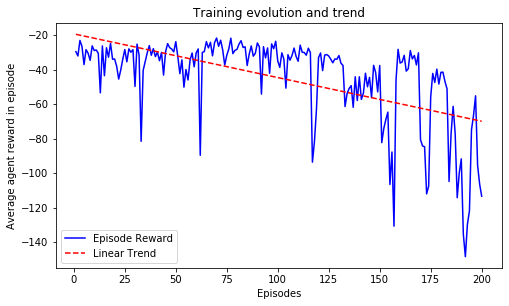

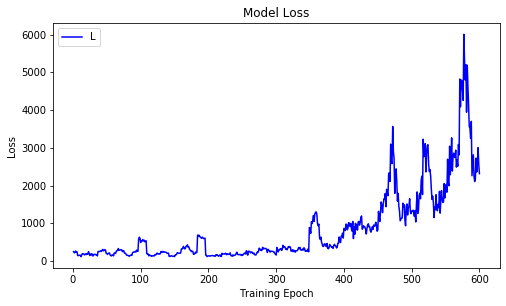

In [6]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [ ]:
# Plotting test progress:
West_queue = list()
South_queue= list()
East_queue = list()
North_queue= list()
# Queue Lengths
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].queues_over_time)+1)
for i in range(len(Agents[0].queues_over_time)):
    West_queue.append(Agents[0].queues_over_time[i][0])
    South_queue.append(Agents[0].queues_over_time[i][1])
    East_queue.append(Agents[0].queues_over_time[i][2])
    North_queue.append(Agents[0].queues_over_time[i][3])
plt.plot(x_series, West_queue, '-b',\
         x_series, South_queue, '-r',\
         x_series, East_queue, '-g',\
         x_series, North_queue, '-y')
plt.xlabel('Time [s]')
plt.ylabel('Queue Length')
plt.title('Training evolution and trend')
plt.gca().legend(('West Queue','South Queue', 'East Queue', 'North Queue'))
plt.show()

# Accumulated delay over time
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].accumulated_delay)+1)
plt.plot(x_series,Agents[0].accumulated_delay, '-b')
plt.xlabel('Time [s]')
plt.ylabel('Accumulated global Delay')
plt.title('Global Delay')
plt.gca().legend('GLlobal accumulated delay')
plt.show()

average_queue_length = np.mean(Agents[0].queues_over_time)
print("Average queue size is {}".format(np.round(average_queue_length,2)))

In [2]:
### SHORT PRETRAINED FROM MEMORY DEMO
# Initialize storage
reward_storage = []
best_agent_weights = []
best_agent_memory = []
reward_plot = np.zeros([episodes,])
loss_plot = np.zeros([episodes,])

# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)

# Setting Random Seed
Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

# Deploy Network Parser (crawl network)
npa = NetworkParser(Vissim)
print('NetworkParser has succesfully crawled the model network.')

# Initialize agents
if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
    Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                       gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                       DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                       Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 
    agents_deployed = True
else:
    print("Incorrect Agent Class selected. Deployment could not be completed.")
    quit()
if agents_deployed:
    print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))

#    memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
#                                                        vissim_working_directory, model_name, Session_ID,\
#                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
#                                                        demand_list, demand_change_timesteps, PER_activated)
#print('Memory pre-populated. Starting Training.\n')

NameError: name 'np' is not defined

In [ ]:
# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)


In [ ]:
npa = NetworkParser(Vissim)

In [ ]:
npa.signal_heads[0]

In [ ]:
Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 


In [ ]:
Agents[0].signal_groups
i=0

In [ ]:
Agents[0].signal_groups[i].SetAttValue("SigState", "RED")
i+=1
print(i)

In [ ]:
# Create SignalHeadsCollection and unpack the SignalHeads into a list by SignalController
signal_heads = [[] for _ in signal_controllers_ids]
for SC in signal_controllers_ids:
    print(SC)
    for SG in range(signal_controllers[SC].SGs.Count):
        print(SG)
        signal_heads[SC].append(toList(signal_groups[SC][SG].SigHeads.GetAll())[0])

In [ ]:
lanes = [[[] for b in range(len(signal_heads[a])) ] for a in signal_controllers_ids]
for SC in signal_controllers_ids:
    for SH in range(len(signal_heads[SC])):
        lanes[SC][SH].append(signal_heads[SC][SH].Lane)

In [ ]:
npa = NetworkParser2(Vissim)

In [ ]:
npa.signal_groups

In [ ]:
import time
for i in range(6000):
    if i % 5 == 0:
        Agents[0].copy_weights()
    Agents[0].learn_batch(64, 0)
    print("Epoch {}:".format(i))
    print("Prediction for [50,0,50,0] is: {}".format(Agents[0].model.predict(np.reshape([50,0,50,0], [1,4])))\
          + ("OK" if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1]  else "NO"))
    true1 = True if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1] else False
    print("Prediction for [0,50,0,50] is: {}".format(Agents[0].model.predict(np.reshape([0,50,0,50], [1,4])))\
         + ("OK" if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1]  else "NO"))
    true2 = True if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1] else False
    if true1 and true2 == True and i>100:
        print("FOUND CANDIDATE AT EPOCH {}. TERMINATING".format(i))
        break

In [ ]:
# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [ ]:
## EXECUTION OF A TEST RUN
SF.Set_Quickmode(Vissim, timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
#timesteps_per_second = 10
#Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
Vissim.Simulation.RunSingleStep()
print(Vissim.Net.QueueCounters.ItemByKey(1).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(2).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(3).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(4).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(5).AttValue('QStops(Current,Last)'))

In [ ]:
if os.path.exists(Filename+"bla"):
    Vissim.LoadNet(Filename+"bla")
else:
    raise Exception("ERROR")

In [ ]:
Vissim.Simulation.RunSingleStep()

In [ ]:
Vissim.Simulation.SetAttValue('SimPeriod', sim_length)
